# This notebook try to validate the code in hp part

In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
from multiprocessing import Pool, Pipe, Process
import tqdm
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.to(u.km/u.s/u.Mpc).value / 100


In [2]:
Nside = 1024
mask = hp.read_map('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/mask/mask.fits')
dat = hp.read_alm('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/MV/dat_klm.fits')
image = hp.sphtfunc.alm2map(dat, nside=Nside, pol=False)
mask = hp.ud_grade(mask, Nside)
image_masked = hp.ma(image)
image_masked.mask = np.logical_not(mask>0.5)
print('finish loading Planck kappa map.')

finish loading Planck kappa map.


In [3]:
z_l = 0.55
d_A = cosmos.angular_diameter_distance(z_l).to(u.Mpc).value
chi_l = d_A*(1+z_l)

(5*u.arcmin).to(u.rad).value*h*(1+z_l)*d_A

2.078262204606502

In [2]:
Npro = 40
Njack = 100
Nbins = 15

r_bins = np.geomspace(3, 100, Nbins+1)        # unit: cMpc/h

sigma_frac = (const.c*const.c/(4*np.pi*const.G)).to(u.Msun*u.Mpc/u.pc/u.pc).value / h
z_s = 1100      # redshift of CMB
chi_s = coo.Distance(z=z_s, cosmology=cosmos).to(u.Mpc).value/(1+z_s)         # comoving distance of CMB

sender, receiver = Pipe(duplex=True)

def stack_single_sample(arg):
    global sender
    """
    To stack around a single position
    Estimator
    \Sigma_l(r) = (\sum_p w_lp \kappa_p \Sigma_c)/(\sum_p w_lp)
    w_lp = w_l * Sigma_c^(-2)
    \Sigma_c = c^c/(4\pi G) \chi_s/(\chi_l (\chi_s-\chi_l) (1+z_l))
    """
    vec = arg[0:3]
    w_l = arg[3]
    z_l = arg[4]
    values = np.zeros(Nbins)
    weights = np.zeros(Nbins)
    
    d_A = cosmos.angular_diameter_distance(z_l).to(u.Mpc).value
    chi_l = d_A*(1+z_l)

    theta_bins = r_bins/h/(1+z_l)/d_A
    # convert from cMpc to theta

    ids = []
    for i in range(Nbins):
        idx_in = hp.query_disc(nside=Nside, vec=vec, radius=theta_bins[i])
        idx_out = hp.query_disc(nside=Nside, vec=vec, radius=theta_bins[i+1])
        idx = np.zeros(len(image_masked), bool)
        idx[idx_out] = True
        idx[idx_in] = False
        # select pixels between bin[i] to bin[i+1]
        ids.append(idx)
        choose = image_masked[idx]
        kappa = choose[np.logical_not(choose.mask)].data
        
        Sigma_c = sigma_frac*chi_s/(chi_l*(chi_s-chi_l)*(1+z_l))*np.ones_like(kappa)        # unit: M_sun/pc^2 h
        # Sigma_c = np.ones_like(kappa)

        w_lp = w_l/Sigma_c/Sigma_c

        weights[i] = np.sum(w_lp)
        if len(w_lp) == 0:
            values[i] = np.nan
        else:
            values[i] = np.sum(w_lp*Sigma_c*kappa)/weights[i]
    if not sender is None:
        sender.send(1)

    return values, weights, ids

In [5]:
z_l = 1
r_bins = np.geomspace(3, 300, 10)
d_A = cosmos.angular_diameter_distance(z_l).to(u.Mpc).value
chi_l = d_A*(1+z_l)

theta_bins = r_bins/h/(1+z_l)/d_A

In [6]:
theta_bins

array([0.00130577, 0.00217816, 0.0036334 , 0.00606087, 0.01011014,
       0.01686473, 0.02813207, 0.04692712, 0.07827915, 0.13057749])

In [13]:
dat = hp.read_alm('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/MV/dat_klm.fits')
image = hp.sphtfunc.alm2map(dat, nside=Nside, pol=False)

In [12]:
z_l = 0.2
d_A = cosmos.angular_diameter_distance(z_l).to(u.Mpc).value
chi_l = d_A*(1+z_l)
r = 30
((r/h/(1+z_l)/d_A)*u.rad).to(u.deg)

<Quantity 3.01152658 deg>

In [12]:
(hp.nside2resol(1024)*u.rad).to(u.arcmin)

<Quantity 3.43548641 arcmin>

In [35]:
v, w, i = stack_single_sample([*hp.ang2vec(np.pi/2, 0), 1, 1])

In [37]:
imap = np.zeros(hp.nside2npix(1024))

In [38]:
for j in range(len(i)):
    imap[i[j]] = j

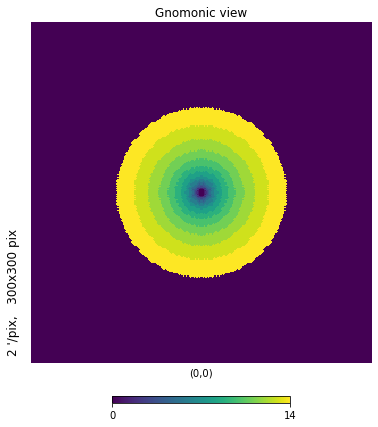

In [42]:
hp.visufunc.gnomview(imap, rot=[0, 0, 0], xsize=300, reso=2, min=0, max=14)

In [2]:
cmass = np.load('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/cmass_z_cut.npy')
Nquas = len(cmass)
c = coo.SkyCoord(ra=cmass['ra']*u.degree, dec=cmass['dec']*u.degree)
l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pos = hp.ang2vec(theta=np.pi/2-b, phi=l)

In [8]:
image_c = np.zeros(hp.nside2npix(1024))
image_c[hp.ang2pix(theta=np.pi/2-b, phi=l, nside=1024)] = 1

finish loading Planck kappa map.


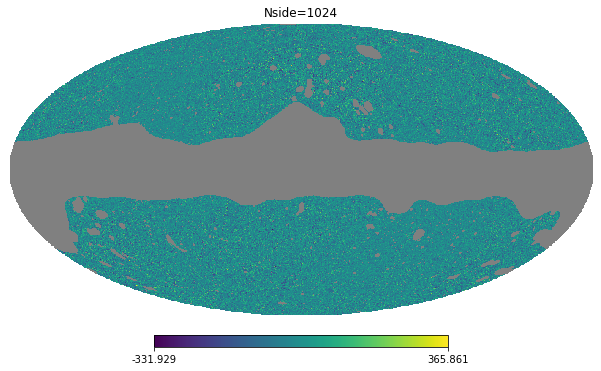

In [6]:
Nside = 1024
mask = hp.read_map('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/mask/mask.fits')
dat = hp.read_alm('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/MV/dat_klm.fits')
image = hp.sphtfunc.alm2map(dat, nside=Nside, pol=False)
mask = hp.ud_grade(mask, Nside)
image_masked = hp.ma(image)
image_masked.mask = np.logical_not(mask>0.5)
print('finish loading Planck kappa map.')
hp.mollview(image_masked.filled(), title='Nside=1024')

In [9]:
quasar_cata = fits.getdata('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/SDSS16Q/DR16Q_v4.fits')
quasar_cata = quasar_cata[quasar_cata['Z'] > 1]
quasar_cata = quasar_cata[quasar_cata['Z'] < 3]
c = coo.SkyCoord(ra=quasar_cata['RA']*u.degree, dec=quasar_cata['DEC']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value

image_q = np.zeros(hp.nside2npix(1024))
image_q[hp.ang2pix(theta=np.pi/2-b, phi=l, nside=1024)] = 1

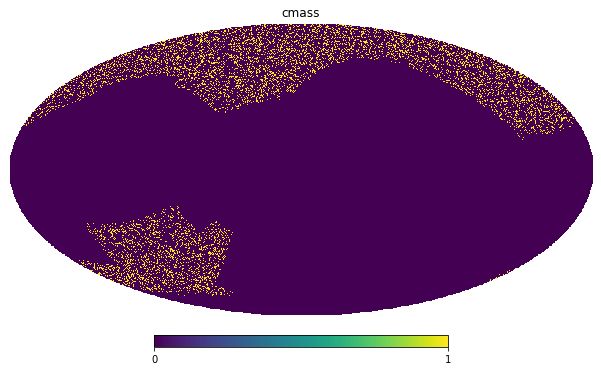

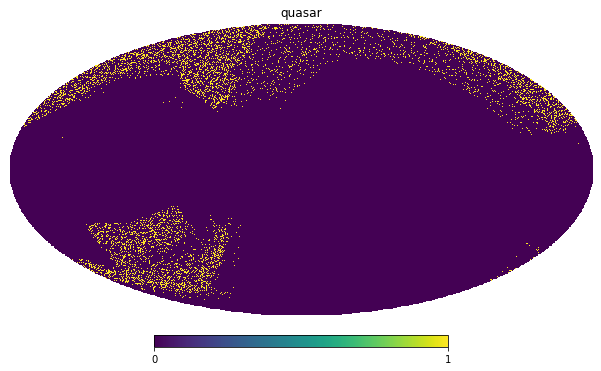

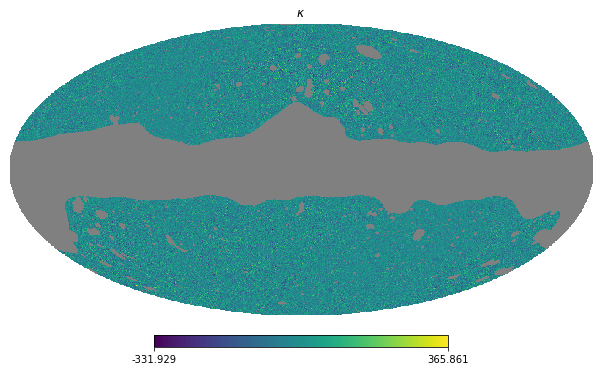

In [11]:
hp.mollview(image_c, title='cmass')
hp.mollview(image_q, title='quasar')
hp.mollview(image_masked.filled(), title='$\\kappa$')

In [14]:
rand_point = np.loadtxt('../random_sample_theta_phi_5_000_000')
image_qr = np.zeros(hp.nside2npix(1024))
image_qr[hp.ang2pix(1024, rand_point[:,0], rand_point[:,1])] = 1

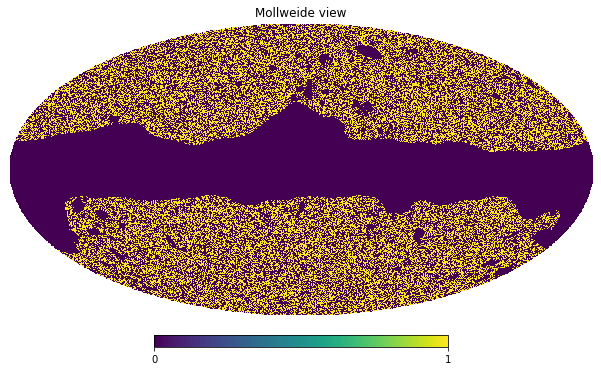

In [18]:
hp.mollview(image_qr)

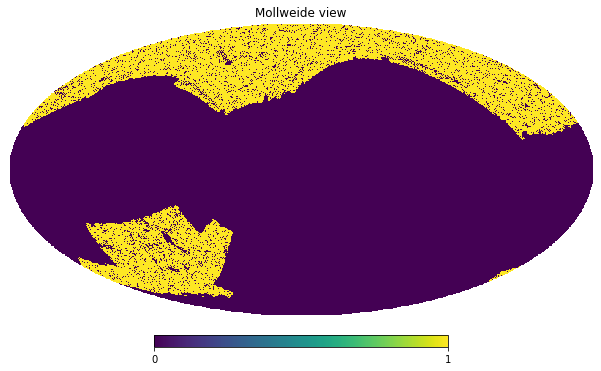

In [19]:
random = np.load('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/cmass_random.npy')
Nquas = len(random)
c = coo.SkyCoord(ra=random['ra']*u.degree, dec=random['dec']*u.degree)
l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value

image_cr = np.zeros(hp.nside2npix(1024))
image_cr[hp.ang2pix(theta=np.pi/2-b, phi=l, nside=1024)] = 1
hp.mollview(image_cr)